# Simple RNN

In [1]:
from cycler import cycler
from itertools import product, count, chain
from pathlib import Path
from string import ascii_uppercase
import time
from typing import Union
import warnings

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from utils import print_nb_info, target_pred_cycler, loss_cycler, SineModel, plot_combinations, print_elapsed_time

In [2]:
warnings.simplefilter("ignore")

In [3]:
print_nb_info()

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.4.0
TensorFlow GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Matplotlib global configuration:

In [4]:
rcParams['font.size'] = '12'
rcParams['figure.figsize'] = (6.4, 4.8)
plt.rc('mathtext', fontset='cm')

Program constants:

In [5]:
SAVEFIG: bool = True
FIG_EXT: str = 'pdf'

In [6]:
out = Path('./out/plots').resolve()

In [9]:
sm1 = SineModel(noise=False, activation=None, fig_path=out)

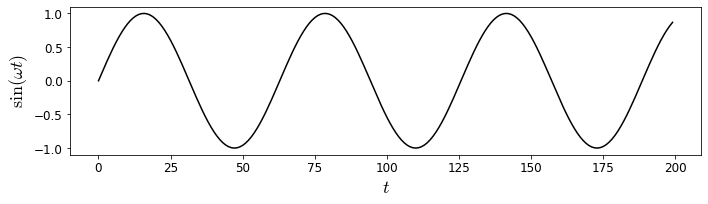

In [10]:
sm1.plot_sine_wave(save=SAVEFIG)

Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_wave_noisy.pdf


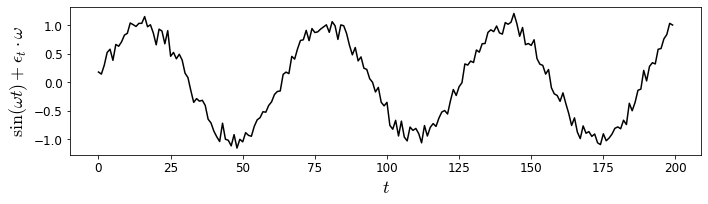

In [7]:
sm2 = SineModel(noise=True, activation=None, fig_path=out)
sm2.plot_sine_wave(save=SAVEFIG)

### Making multiple predictions to check sensitivity

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_none_5x3.pdf
Elapsed time: 151 seconds


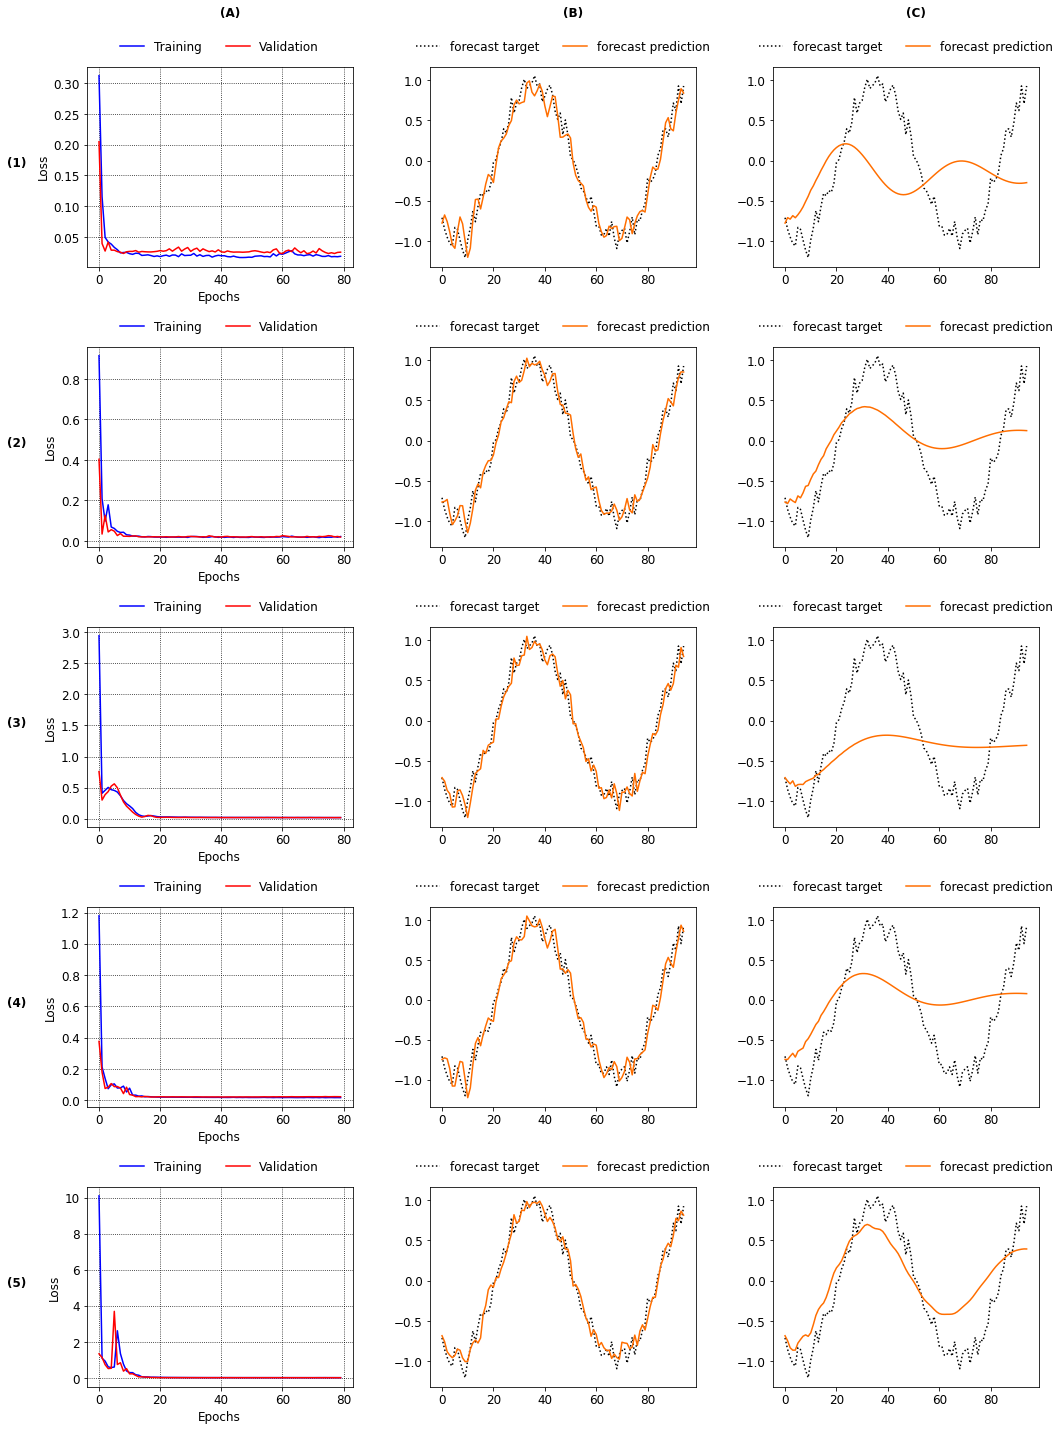

In [95]:
start: float = time.time()
x = 5
sm = SineModel(noise=True, activation=None, fig_path=out)
legend_params = dict(loc='center', bbox_to_anchor=(0.5, 1.1), edgecolor='none',
                     fancybox=True, ncol=2, framealpha=1, facecolor='none')
counter = count(1)
alpha_counter = chain(ascii_uppercase)
vspace = 4

fig = plt.figure(figsize=(15, vspace * x))
rcParams['axes.prop_cycle'] = target_pred_cycler
for i in range(1, x + 1):
    sm.build_train_simple_rnn(verbose=False)
    
    # Loss per iteration
    ax1 = fig.add_subplot(x, 3, next(counter))
    ax1.plot(sm.history.history['loss'], label='Training', c='b', ls='-')
    ax1.plot(sm.history.history['val_loss'], label='Validation', c='r', ls='-')
    ax1.legend(**legend_params)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(c='k', ls=':')
    ax1.annotate(f"({i})", xy=(-0.3, 0.5), annotation_clip=False, textcoords='axes fraction', fontweight='bold')

    # Wrong forecast
    ax2 = fig.add_subplot(x, 3, next(counter))
    sm.predict(is_wrong=True)
    ax2.plot(sm.validation_target, label='forecast target')
    ax2.plot(sm.validation_predictions, label='forecast prediction')
    ax2.legend(**legend_params)
    
    # Right forecast
    ax3 = fig.add_subplot(x, 3, next(counter), sharey=ax2)
    sm.predict(is_wrong=False)
    ax3.plot(sm.validation_target, label='forecast target')
    ax3.plot(sm.validation_predictions, label='forecast prediction')
    ax3.legend(**legend_params)
    
    if i == 1:
        ax1.annotate(f"({next(alpha_counter)})",
                     xy=(0.5, 1.25),
                     annotation_clip=False,
                     textcoords='axes fraction',
                     fontweight='bold')
        ax2.annotate(f"({next(alpha_counter)})",
                     xy=(0.5, 1.25),
                     annotation_clip=False,
                     textcoords='axes fraction',
                     fontweight='bold')
        ax3.annotate(f"({next(alpha_counter)})",
                     xy=(0.5, 1.25),
                     annotation_clip=False,
                     textcoords='axes fraction',
                     fontweight='bold')

fig.tight_layout()
if SAVEFIG:
    filename = out / f'sine_noise_none_{x}x3.{FIG_EXT}'
    fig.savefig(filename)
    print(f"Saved plot in {filename}")
fig.show()
print_elapsed_time(start)

In [58]:
def plot_n_samples(num_samples: int = 5, 
                   noise: bool = False,
                   activation=None,
                   epochs: int = 80,
                   loss='mse',
                   learning_rate: float = 0.1,
                   save: bool = False,
                   extension: str = 'pdf',
                   shift_row_counter: int = 0,
                   fig_path: Optional[Path] = None):
    start: float = time.time()
    n = num_samples
    fig_path: Path = Path('.').resolve() if None else fig_path
    sm = SineModel(noise=noise, activation=activation, fig_path=fig_path)
    legend_params = dict(loc='center', bbox_to_anchor=(0.5, 1.1), edgecolor='none',
                         fancybox=True, ncol=2, framealpha=1, facecolor='none')
    counter = count(1)
    alpha_counter = chain(ascii_uppercase)
    vspace = 4

    fig = plt.figure(figsize=(15, vspace * n))
    rcParams['axes.prop_cycle'] = target_pred_cycler
    rcParams['font.size'] = 12
    for i in range(1, n + 1):
        sm.build_train_simple_rnn(verbose=False, epochs=epochs, loss=loss, lr=learning_rate)

        # Loss per iteration
        ax1 = fig.add_subplot(n, 3, next(counter))
        ax1.plot(sm.history.history['loss'], label='Training', c='b', ls='-')
        ax1.plot(sm.history.history['val_loss'], label='Validation', c='r', ls='-')
        ax1.legend(**legend_params)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.grid(c='k', ls=':')
        ax1.annotate(f"({i + shift_row_counter})", xy=(-0.3, 0.5), annotation_clip=False, textcoords='axes fraction', 
                     fontweight='bold')

        # Wrong forecast
        ax2 = fig.add_subplot(n, 3, next(counter))
        sm.predict(is_wrong=True)
        ax2.plot(sm.validation_target, label='forecast target')
        ax2.plot(sm.validation_predictions, label='forecast prediction')
        ax2.legend(**legend_params)

        # Right forecast
        ax3 = fig.add_subplot(n, 3, next(counter), sharey=ax2)
        sm.predict(is_wrong=False)
        ax3.plot(sm.validation_target, label='forecast target')
        ax3.plot(sm.validation_predictions, label='forecast prediction')
        ax3.legend(**legend_params)

        if i == 1 + shift_row_counter:  # if shift_row_counter > 0, it will not annotate
            ax1.annotate(f"({next(alpha_counter)})",
                         xy=(0.5, 1.25),
                         annotation_clip=False,
                         textcoords='axes fraction',
                         fontweight='bold')
            ax2.annotate(f"({next(alpha_counter)})",
                         xy=(0.5, 1.25),
                         annotation_clip=False,
                         textcoords='axes fraction',
                         fontweight='bold')
            ax3.annotate(f"({next(alpha_counter)})",
                         xy=(0.5, 1.25),
                         annotation_clip=False,
                         textcoords='axes fraction',
                         fontweight='bold')

    fig.tight_layout()
    if save:
        name: str = 'sine'
        name += '_noise' if noise else ''
        name += f"_{str(activation).lower()}"
        name += f"_{loss}"
        name += f"_lr{learning_rate:.0e}"
        name += f"_{n}x3.{extension}"
        filename = fig_path / name
        fig.savefig(filename)
        print(f"Saved plot in {filename}")
    fig.show()
    print_elapsed_time(start)

### Sine wave without noise and activation function

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_none_1x3.pdf
Elapsed time: 14 seconds


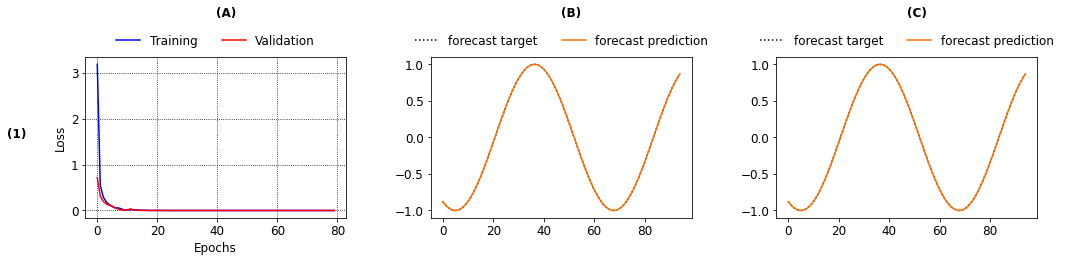

In [107]:
plot_n_samples(num_samples=1, save=SAVEFIG, extension=FIG_EXT)

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_none_5x3.pdf
Elapsed time: 72 seconds


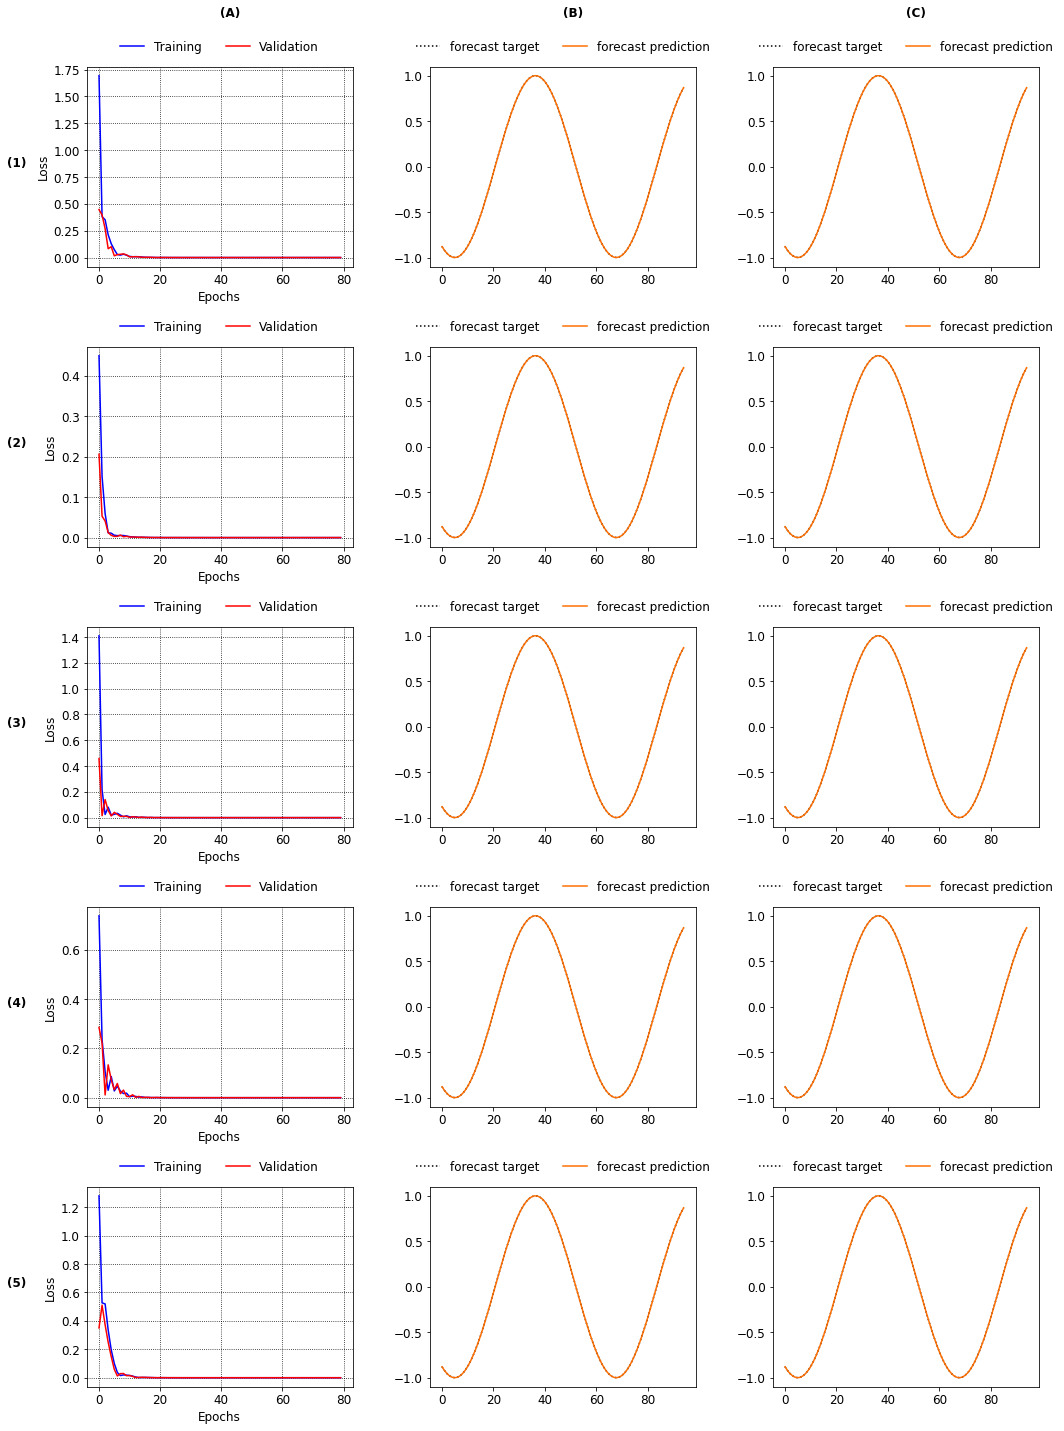

In [101]:
plot_n_samples(save=SAVEFIG, extension=FIG_EXT)

## Sine wave without noise, with tanh

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_tanh_5x3.pdf
Elapsed time: 137 seconds


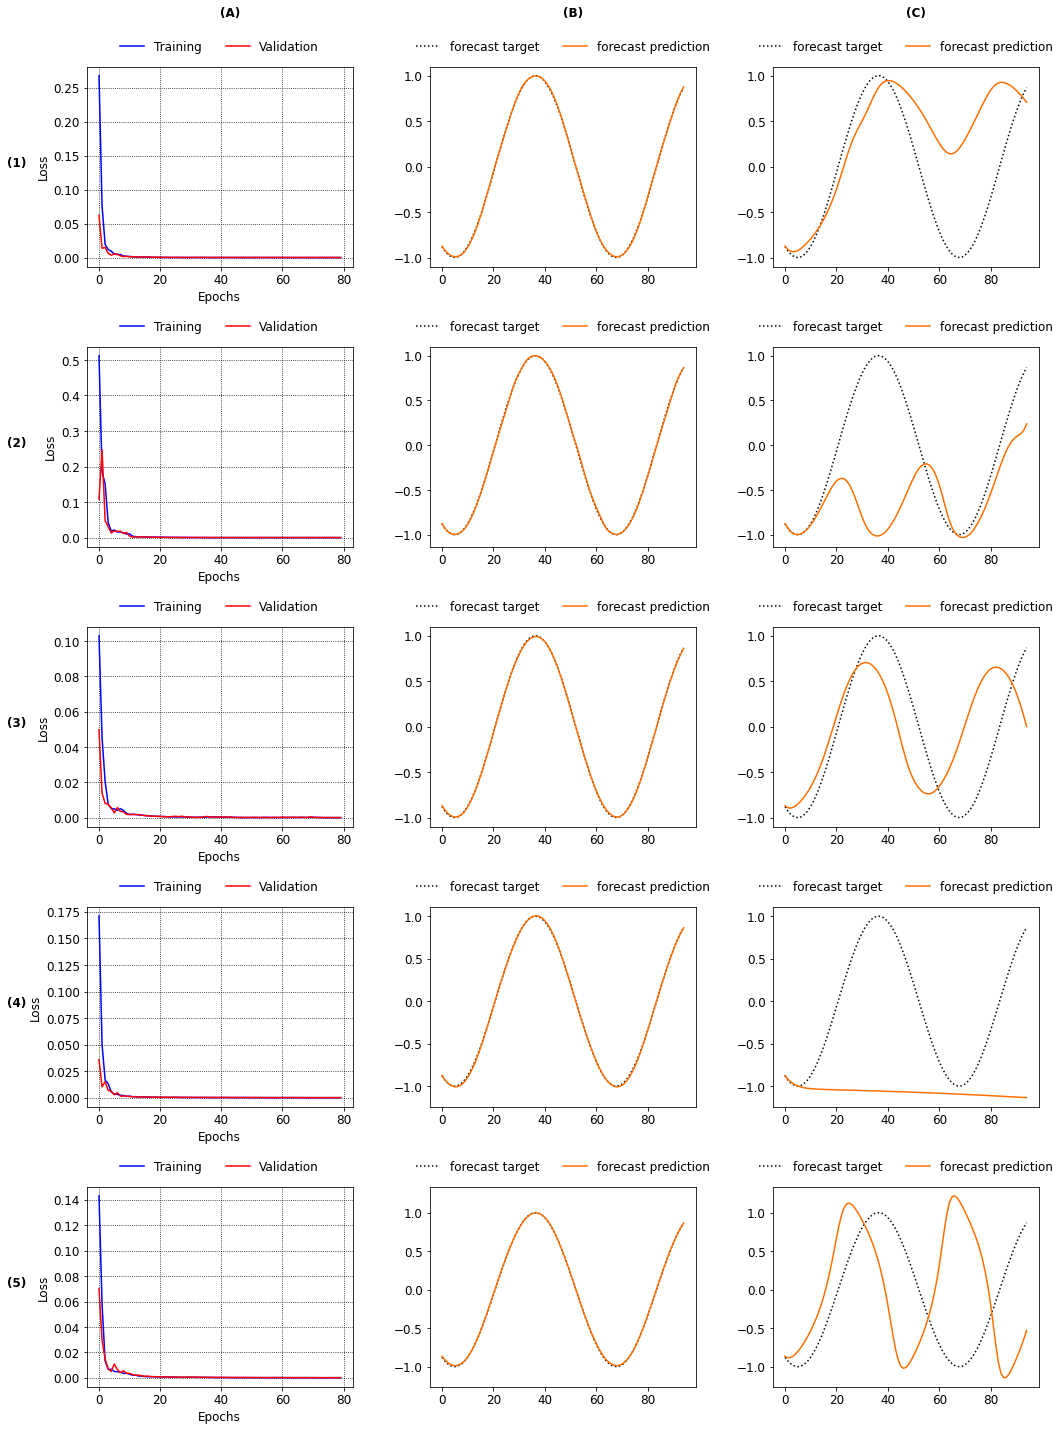

In [102]:
plot_n_samples(activation='tanh', save=SAVEFIG, extension=FIG_EXT)

### Sine wave with noise and tanh

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_tanh_5x3.pdf
Elapsed time: 152 seconds


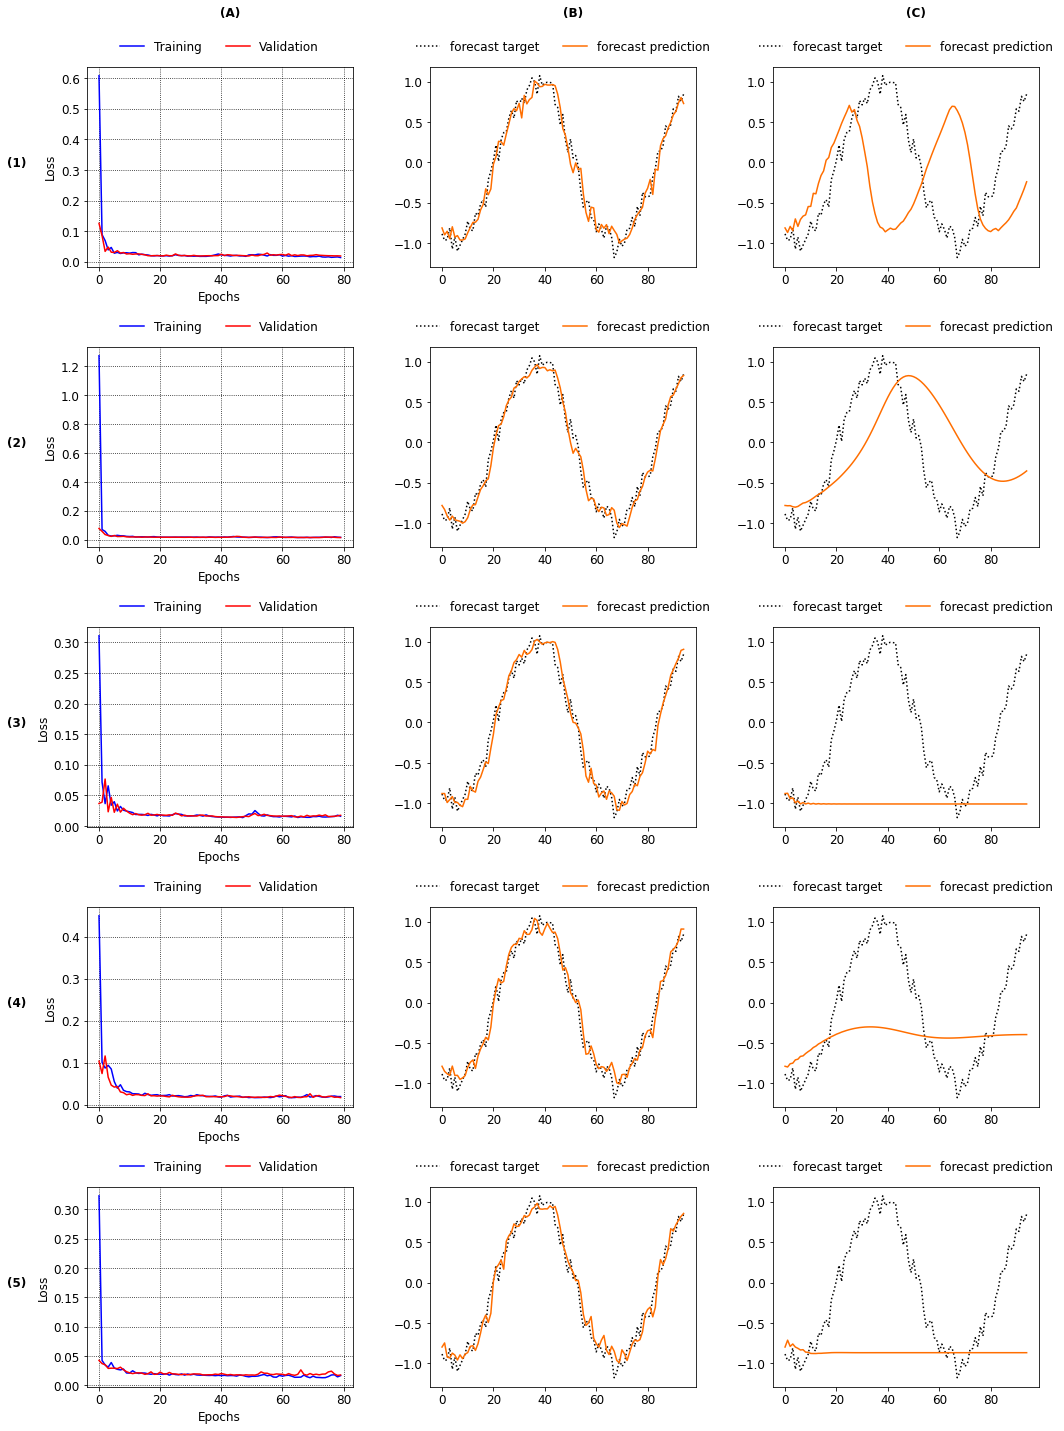

In [103]:
plot_n_samples(noise=True, activation='tanh', save=SAVEFIG, extension=FIG_EXT)

### Sine wave without noise, with ReLU

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_relu_5x3.pdf
Elapsed time: 102 seconds


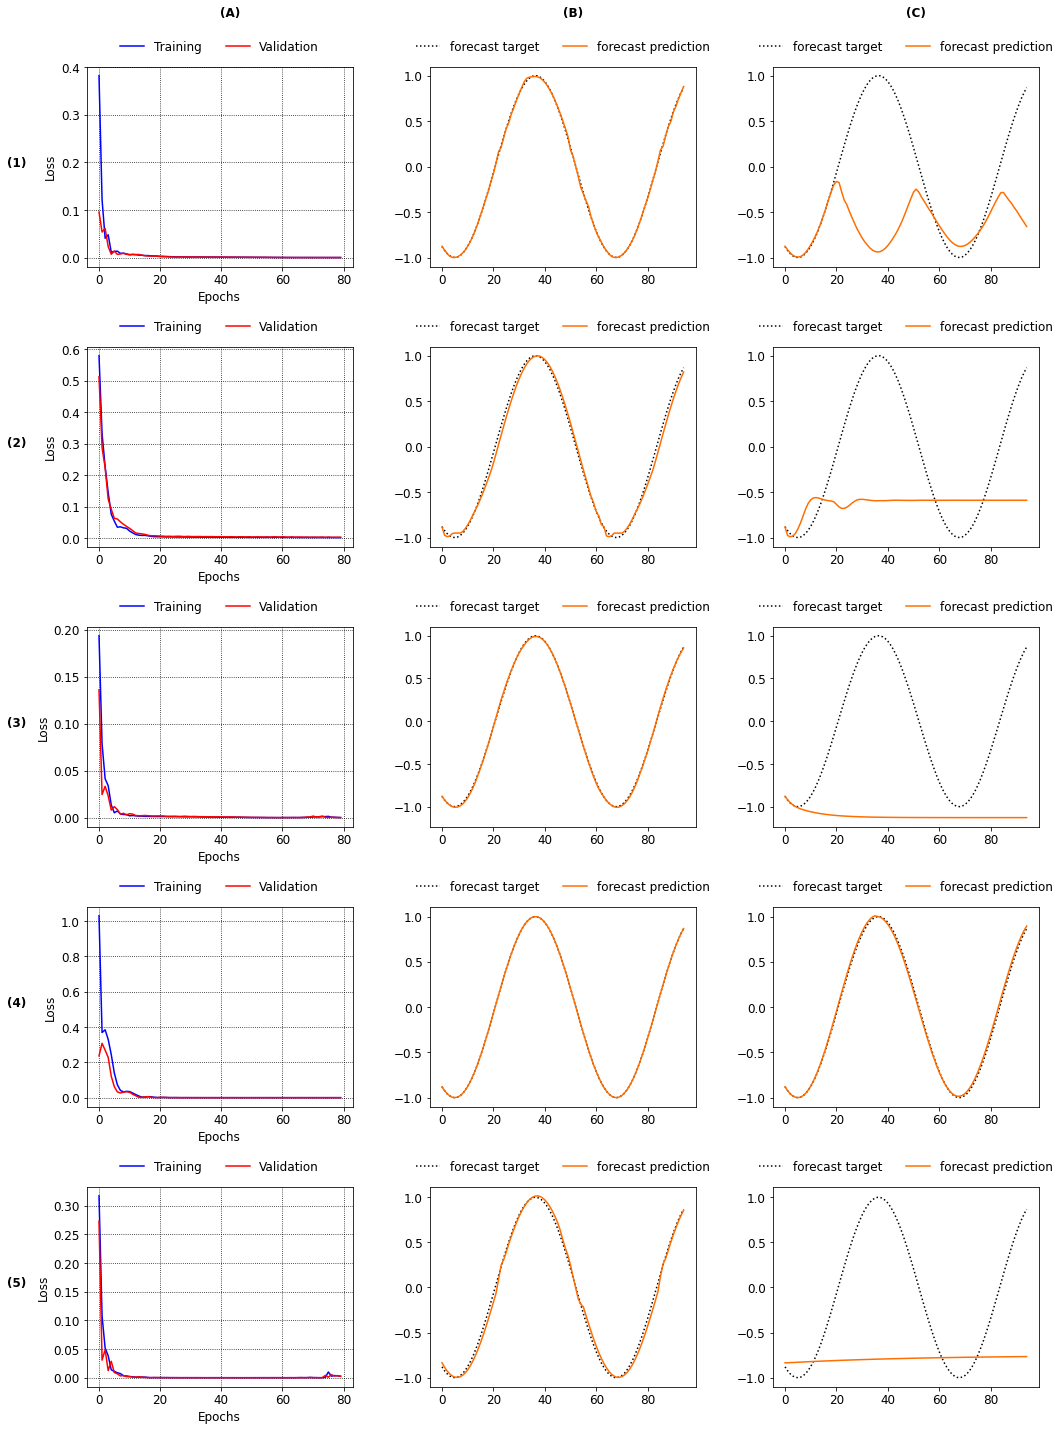

In [105]:
plot_n_samples(activation='relu', save=SAVEFIG, extension=FIG_EXT)

### Sine wave with noise and with ReLU

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_relu_5x3.pdf
Elapsed time: 104 seconds


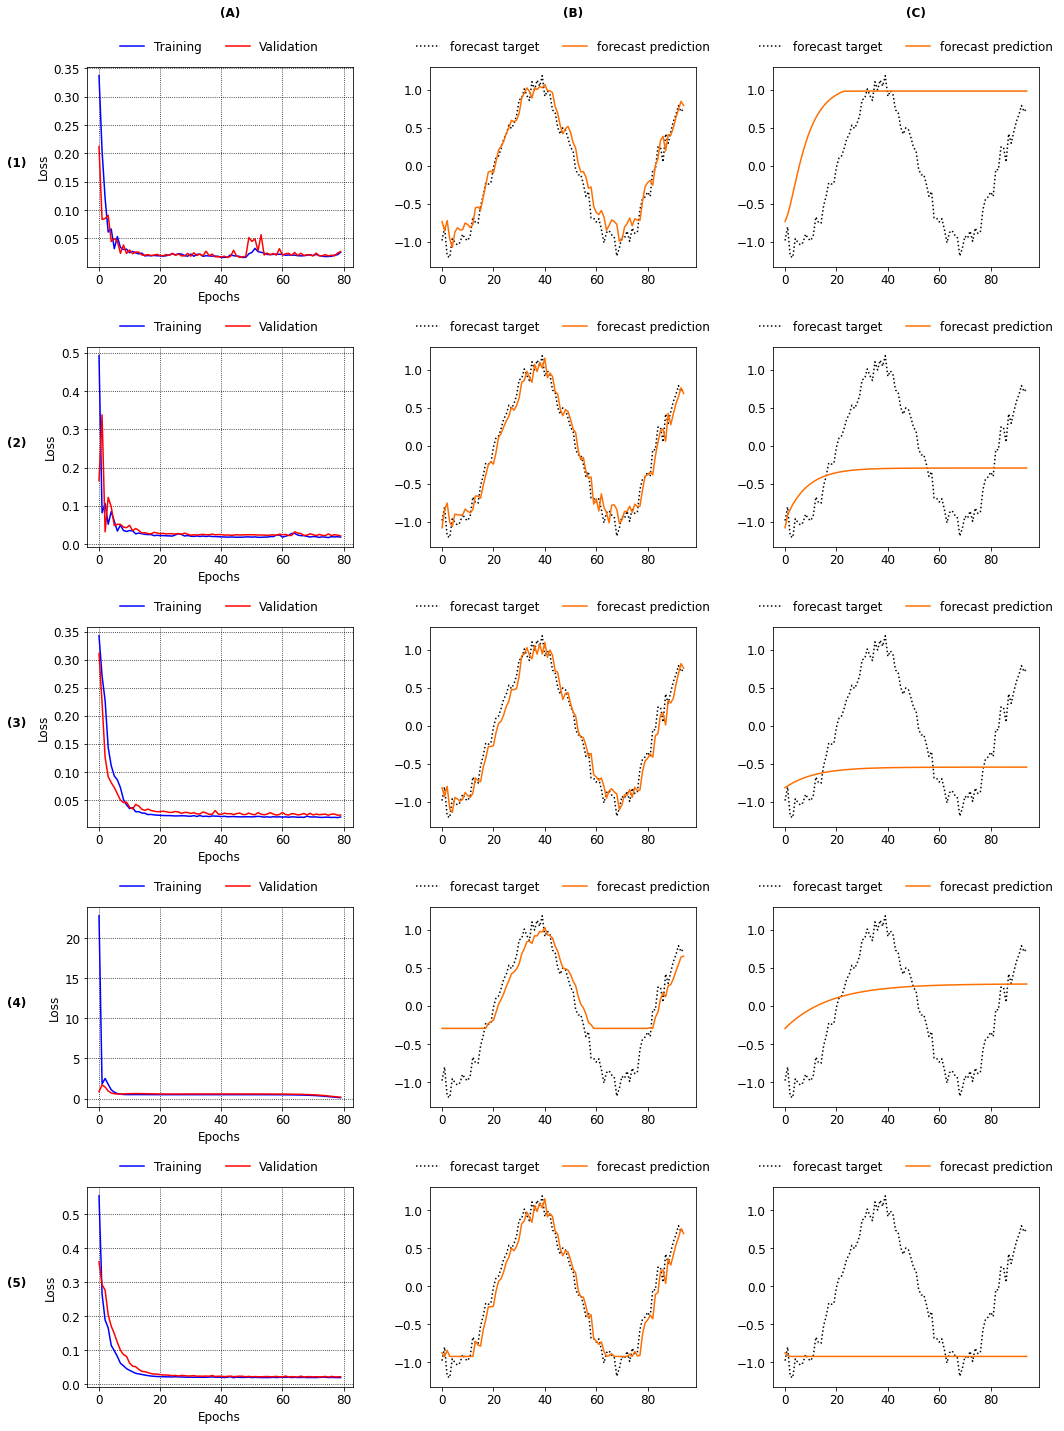

In [106]:
plot_n_samples(noise=True, activation='relu', save=SAVEFIG, extension=FIG_EXT)

## Changing the loss function
### No activation function

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_none_mae_lr1e-01_2x3.pdf
Elapsed time: 36 seconds


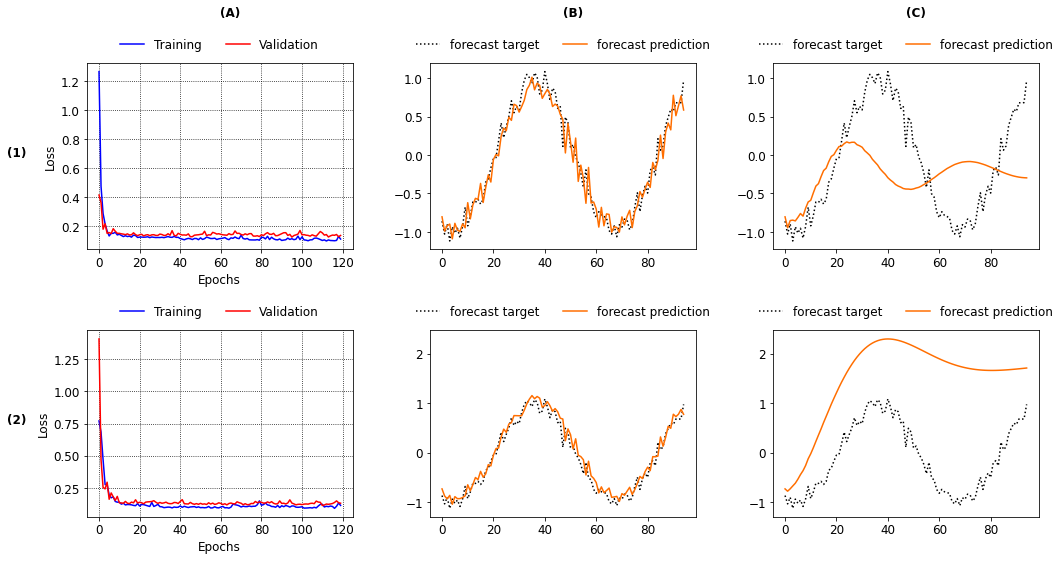

In [48]:
plot_n_samples(num_samples=2, noise=True, activation=None, save=SAVEFIG, extension=FIG_EXT, epochs=120, loss='mae')

### tanh

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_tanh_mae_lr1e-01_2x3.pdf
Elapsed time: 37 seconds


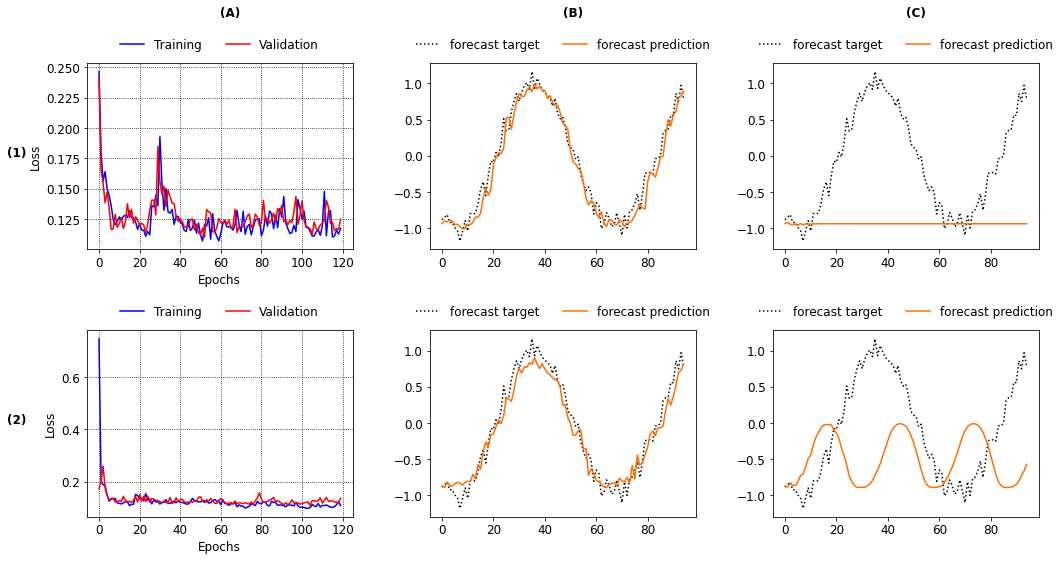

In [49]:
plot_n_samples(num_samples=2, noise=True, activation='tanh', save=SAVEFIG, extension=FIG_EXT, epochs=120, loss='mae')

### ReLU

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_relu_mae_lr1e-01_2x3.pdf
Elapsed time: 56 seconds


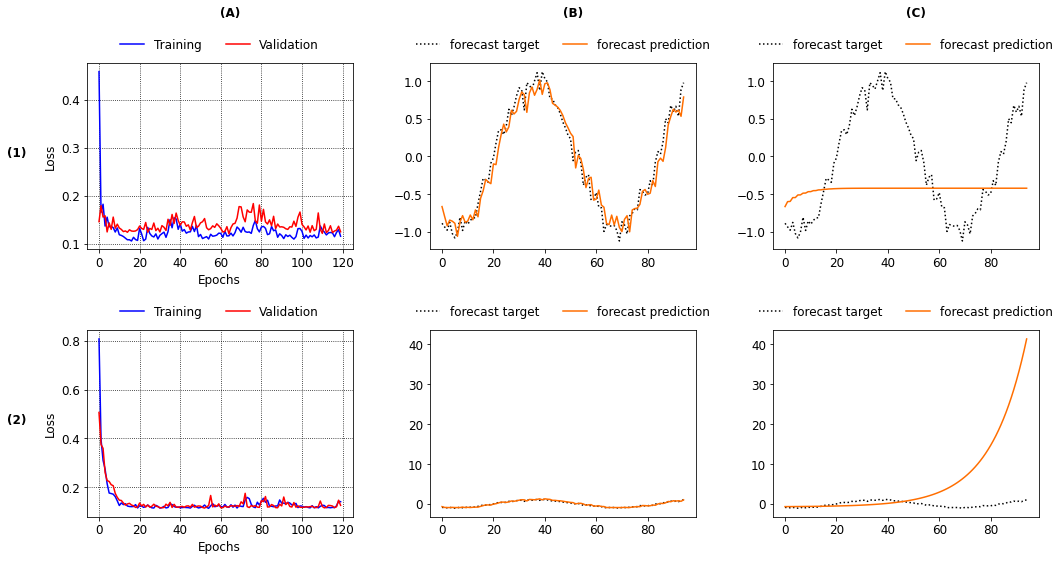

In [51]:
plot_n_samples(num_samples=2, noise=True, activation='relu', save=SAVEFIG, extension=FIG_EXT, epochs=120, loss='mae')

## Changing learning rate in Adam optimizer
### No activation function

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_none_mse_lr1e-02_2x3.pdf
Elapsed time: 40 seconds


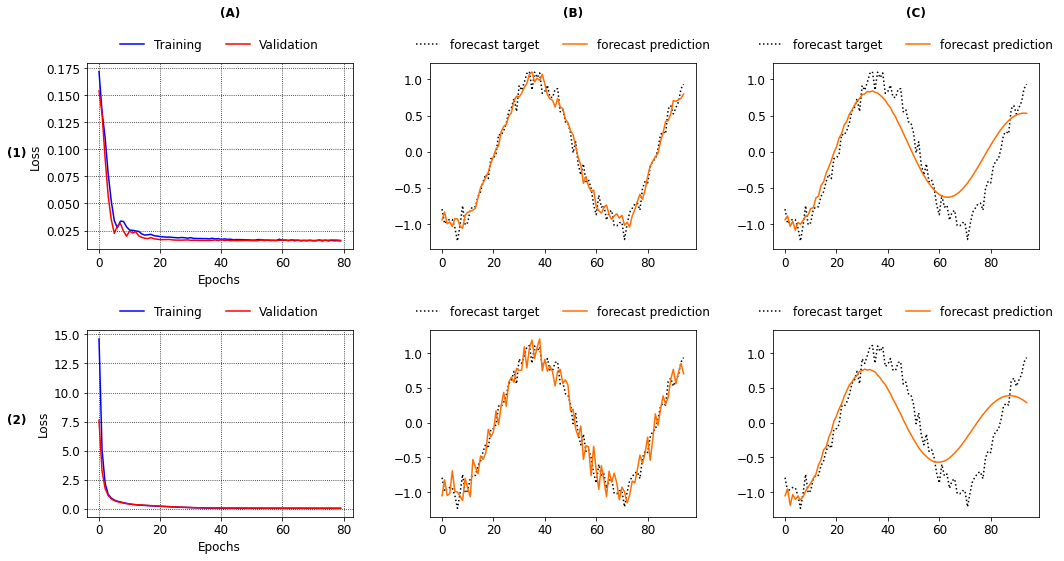

In [59]:
plot_n_samples(num_samples=2, noise=True, activation=None, learning_rate=0.01, save=SAVEFIG, extension=FIG_EXT)

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_none_mse_lr1e-03_2x3.pdf
Elapsed time: 42 seconds


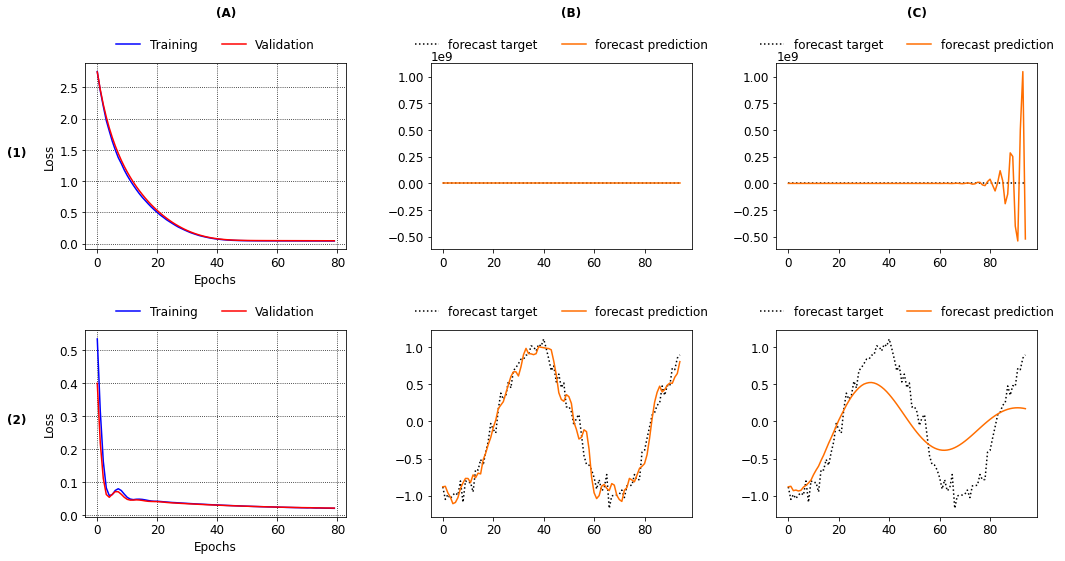

In [63]:
plot_n_samples(num_samples=2, noise=True, activation=None, learning_rate=0.001, save=SAVEFIG, extension=FIG_EXT)

### tanh

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_tanh_mse_lr1e-02_2x3.pdf
Elapsed time: 48 seconds


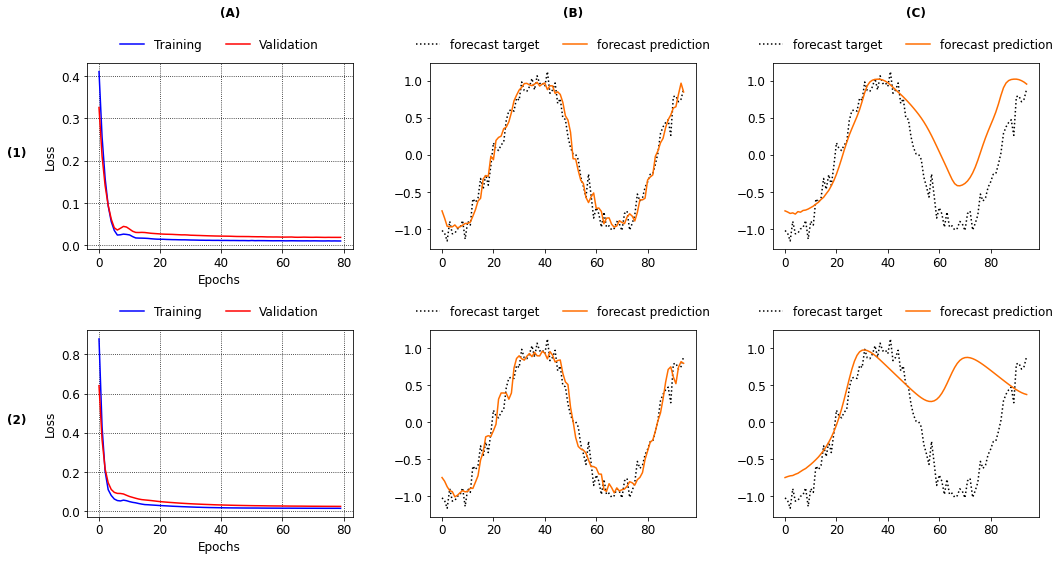

In [64]:
plot_n_samples(num_samples=2, noise=True, activation='tanh', learning_rate=0.01, save=SAVEFIG, extension=FIG_EXT)

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_tanh_mse_lr1e-03_2x3.pdf
Elapsed time: 45 seconds


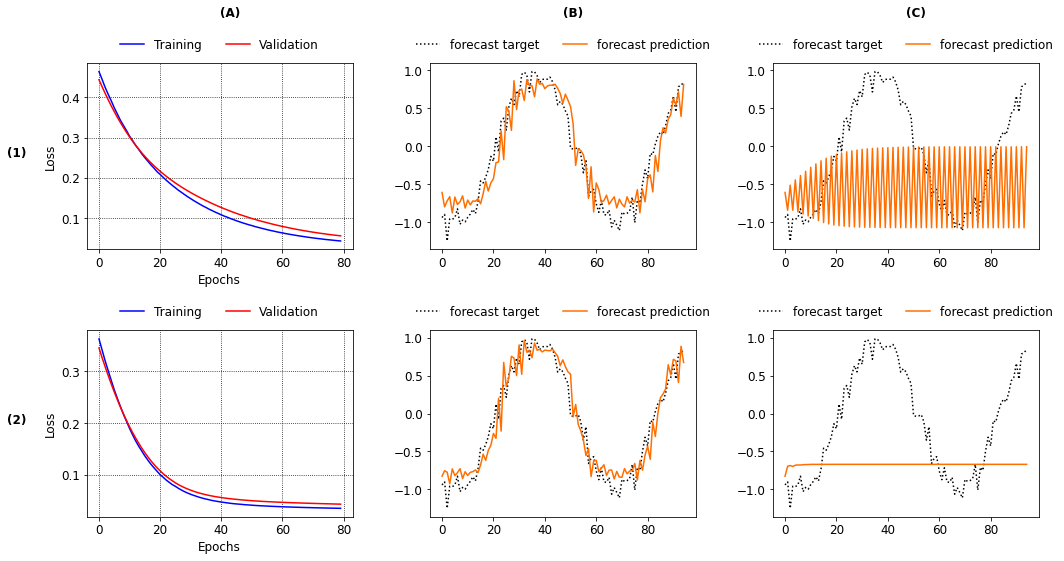

In [65]:
plot_n_samples(num_samples=2, noise=True, activation='tanh', learning_rate=0.001, save=SAVEFIG, extension=FIG_EXT)

### ReLU

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_relu_mse_lr1e-02_2x3.pdf
Elapsed time: 44 seconds


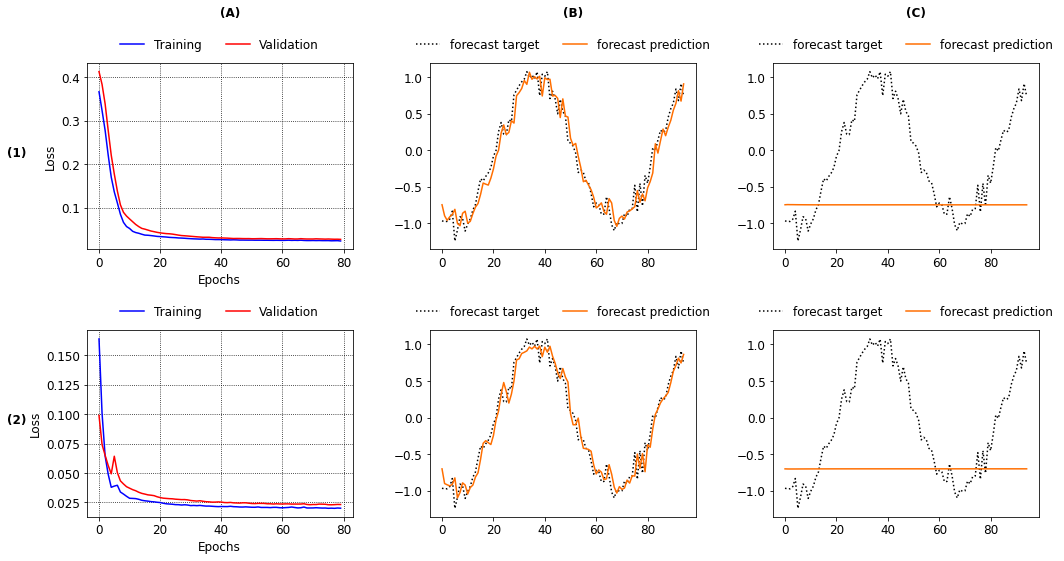

In [66]:
plot_n_samples(num_samples=2, noise=True, activation='relu', learning_rate=0.01, save=SAVEFIG, extension=FIG_EXT)

WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
WRONG FORECAST (-> the forecast is subject to 'look-ahead bias')
RIGHT FORECAST (-> the forecast does not exhibit 'look-ahead bias')
Saved plot in C:\Users\YBant\Documents\projects\deep_learning\rnn\out\plots\sine_noise_relu_mse_lr1e-03_2x3.pdf
Elapsed time: 53 seconds


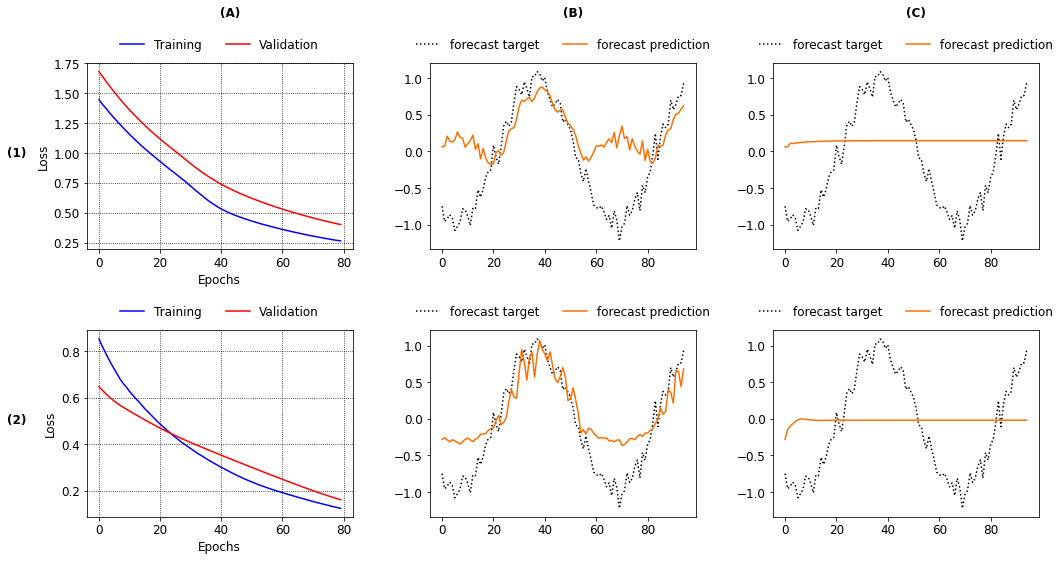

In [67]:
plot_n_samples(num_samples=2, noise=True, activation='relu', learning_rate=0.001, save=SAVEFIG, extension=FIG_EXT)